# K-Nearest Neighbor Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [2]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', regression=False, normalize=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.regression = regression
        self.normalize = normalize

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        
        self.X = data
        self.y = labels
        
        if self.normalize:
            for i in range(self.X.shape[1]):
                self.X[:,i] = (self.X[:,i] - self.X[:,i].min()) / (self.X[:,i].max() - self.X[:,i].min())
        
        return self
    
    def predict(self, data, k):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        
        prediction = []
        classes = np.unique(self.y)
        
        if self.normalize:
            for i in range(data.shape[1]):
                data[:,i] = (data[:,i] - data[:,i].min()) / (data[:,i].max() - data[:,i].min())

        for i in range(data.shape[0]):
            dist = np.zeros(self.X.shape[0])
            dist = np.linalg.norm(self.X - data[i], axis=1)
            nearest = np.zeros((k),int)
            alt_dist = np.copy(dist)
            for n in range(nearest.shape[0]):
                nearest[n] = np.argmin(alt_dist)
                alt_dist[nearest[n]] = np.inf
            votes = np.zeros(classes.shape[0])
            for n in range(nearest.shape[0]):
                vote = np.where(classes == self.y[nearest[n]])[0][0]
                if self.weight_type == 'inverted_distance':
                    weight = 1 / (dist[n] ** 2)
                else:
                    weight = 1
                votes[vote] += weight
            prediction.append(classes[np.argmax(votes)])
        return np.reshape(prediction, (-1,1))

    #Returns the Mean score given input data and labels
    def score(self, data, labels, k):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        
        predictions = self.predict(data, k)
        score = 0
        for i in range(labels.shape[0]):
            if labels[i] == predictions[i]:
                score += 1
        score = score / labels.shape[0]
        
        return score
    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [3]:
# Load seismic bumps data

data = arff.loadarff('datasets/seismic-bumps_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X = data[:,:-1].astype(np.float64)
y = data[:,-1]

knn = KNNClassifier([], 'inverse_distance')

# Train on training set

knn.fit(X, y)

# Predict on test set

data = arff.loadarff('datasets/seismic-bumps_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X = data[:,:-1].astype(np.float64)
y = data[:,-1]

knn.score(X, y, 3)

0.9357142857142857

### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [4]:
# Load diabetes data

data = arff.loadarff('datasets/diabetes_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X = data[:,:-1].astype(np.float64)
y = data[:,-1]

knn = KNNClassifier([], 'inverse_distance')

# Train on training set

knn.fit(X, y)

# Predict on test set

data = arff.loadarff('datasets/diabetes_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X = data[:,:-1].astype(np.float64)
y = data[:,-1]

knn.score(X, y, 3)

0.8411458333333334

## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [5]:
# Load magic telescope data

data = arff.loadarff('datasets/magic_telescope_train.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X = data[:,:-1].astype(np.float64)
y = data[:,-1]

knn = KNNClassifier([], None)

# Train/Predict without normalization

knn.fit(X,y)

data = arff.loadarff('datasets/magic_telescope_test.arff')
df = pd.DataFrame(data[0])
data = np.array(df)

X_test = data[:,:-1].astype(np.float64)
y_test = data[:,-1]

knn.score(X_test,y_test,3)

0.8082808280828083

### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [6]:
# Train/Predict with normalization

knn = KNNClassifier([], None, False, True)

knn.fit(X,y)

knn.score(X_test,y_test, 3)


0.8157815781578158

*Discuss the accuracy results of using normalized data vs. unnormalized data*

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

Text(0, 0.5, 'accuracy')

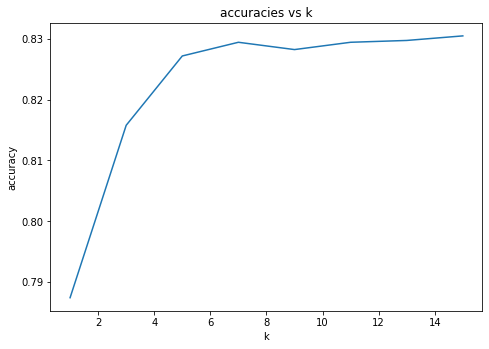

In [16]:
# Train/Predict with normalization using k=1,3,...,15

accuracies = []

for g in range(1,16, 2):
    accuracies.append(knn.score(X_test, y_test, g))

# Graph classification accuracy over k

ks = np.arange(1, 16, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(ks, accuracies)
ax.set_title("accuracies vs k")
ax.set_xlabel("k")
ax.set_ylabel("accuracy")

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


In [8]:
# Load housing price prediction data

# Train/Predict using k=1,3,...,15

# Graph MSE over k


## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


In [9]:
# Train/Predict magic telescope using distance-weighted voting

# Train/Predict housing using distance-weighted voting


*Discuss your results*

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [10]:
# Load dataset and split into train/test sets

# Train/Predict credit-approval


*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [11]:
# Train/Predict magic telescope using scikit's KNN

# Train/Predict housing using scikit's KNN


*Report your comparison*

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
